In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
from skimage.transform import rescale, resize

## Load Data

In [2]:
img_list = np.load('test_npy/7-12-17-preprocessed.npy')

print('Image size: ', img_list.shape[1])

Image size:  203


## Resize Image

In [3]:
re_list = []
for i in range(len(img_list)):
    img_re = resize(img_list[i], (200, 200), anti_aliasing=False)
    re_list.append(img_re)
    
re_list = np.asarray(re_list)

IMG_SIZE = re_list.shape[1]
print('New image size: ', IMG_SIZE)

/home/kevinteng/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


New image size:  200


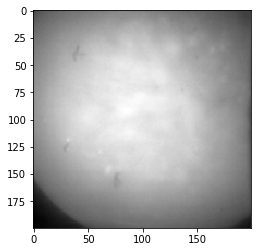

In [4]:
for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    break
    
#     if input()=='exit':
#         break

In [5]:
print(np.min(re_list[0]))
print(np.max(re_list[0]))

0.1490782107843141
0.7914949264705882


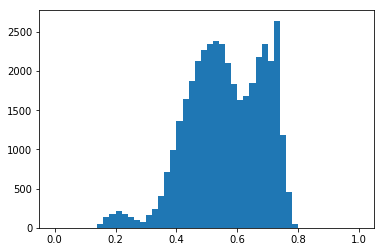

In [6]:
#plot historgram 
plt.hist(re_list[0].ravel(),50,[0,1])
plt.show()

In [7]:
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)

#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

In [8]:
BATCH_SIZE = 16
MAX_STEP = 5000
REPEAT = 50
lr = 1e-3

ds_train = tf.data.Dataset.from_tensor_slices(re_list).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
l1_coeff = 0.01
#filter_size = [32, 48, 64, 80] 
#filter_size = [128, 64, 32, 16]
filter_size = [32, 48, 64, 128]

def conv_block(x_in, filters, kernel_size, strides, padding, activation, kernel_regularizer = False,    
               batch_norm = False, max_pool = False):
    '''
    Build convolutional block with batch normalization
    '''
    if kernel_regularizer:
        print('L1 regularizer is activate!')
        x = Conv2D(filters, kernel_size, strides, padding, kernel_regularizer = l1(l1_coeff))(x_in)
    else:
        x = Conv2D(filters, kernel_size, strides, padding)(x_in)
        
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    if max_pool:
        assert strides < 2 or strides < (2,2), "Downsampling too fast for strides greater than 2"
        
        x = MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same')(x)
        
    return x 

def coordconv_block(x_in, x_dim, y_dim, filters, kernel_size, strides, padding, activation,  
              kernel_regularizer = False, batch_norm = False, max_pool = False, with_r = False):
    '''
    Build coordconv block with batch normalization
    '''
    if kernel_regularizer:
        print('L1 regularizer is activate!')
        x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, 
                      strides, padding, kernel_regularizer = l1(l1_coeff))(x_in)
    else:
        x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, strides, padding)(x_in)
    
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    if max_pool:
        assert strides < 2 or strides < (2,2), "Downsampling too fast for strides greater than 2"
        
        x = MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same')(x)
        
    return x 

def up_block(x_in, up_size, filters, kernel_size, strides, padding, activation,
             batch_norm = False):
    '''
    Build upsampling block with upsamping + convolutional operation
    '''
    u = UpSampling2D(up_size)(x_in)
    #by default during upsampling Conv2D does not need maxpooling!
    conv_u = conv_block(u, filters, kernel_size, strides, padding, activation, batch_norm)
    return conv_u

def up_coord_block(x_in, up_size, xdim, ydim, filters, kernel_size, strides, padding, activation,
             batch_norm = False):
    '''
    Build upsampling block with upsamping + coordconv operation
    '''
    u = UpSampling2D(up_size)(x_in)
    #by default during upsampling Conv2D does not need maxpooling!
    coordconv_u = coordconv_block(u, xdim, ydim, filters, kernel_size, strides, padding, activation, batch_norm)
    return coordconv_u

def encoder(input_layer,coordconv = False, dense_out = False):
    '''
    Encoder part of the autoencoder
    Params:
    input_layer: Input((shape))
    coordconv: toggle for coordconv in every layer for encoder
    dense_out: if true, bottle neck layer will be dense layer
    '''
    print('Encoder:')
    if coordconv:
        coordconv_01 = coordconv_block(input_layer, x_dim = 200, y_dim = 200, 
                                      filters = filter_size[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)

        coordconv_02 = coordconv_block(coordconv_01, x_dim = 200, y_dim = 200, 
                                      filters = filter_size[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True, max_pool = True)
        #add l1 regularizer in the last layer 
        coordconv_03 = coordconv_block(coordconv_02, x_dim = 100, y_dim = 100,
                                      filters = filter_size[2], kernel_size = 3, strides = 1, padding='same', 
                                    activation='relu', kernel_regularizer = True, 
                                       batch_norm = True, max_pool = True)
        
    else:
        conv_01 = conv_block(input_layer, filters = filter_size[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True)
    
        conv_02 = conv_block(conv_01, filters = filter_size[1],kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', batch_norm = True, max_pool = True)
        
        conv_03 = conv_block(conv_02, filters = filter_size[2],kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', kernel_regularizer = True, 
                             batch_norm = True, max_pool = True)
    
    if dense_out:
        print('dense_out for encoder')
        if coordconv:
            print('coordconv for dense_out')
            
            flat_01 = Flatten()(coordconv_03)
            dense_01 = Dense(latent_dim)(flat_01)

        else:
            print('convnet for dense_out')
            
            flat_01 = Flatten()(conv_03)
            dense_01 = Dense(latent_dim)(flat_01)

        return dense_01 
    
    elif coordconv:
        print('coordconv_out for encoder')
        coord_conv04 = coordconv_block(coordconv_03, x_dim = 50, y_dim = 50,
                                      filters = filter_size[3], kernel_size = 3, strides = 1,
                                      padding = 'same', activation='linear', max_pool = True)
        return coord_conv04
    else:
        print('convnet_out for encoder')
        conv_04 = conv_block(conv_03, filters = filter_size[3],kernel_size = 3, strides = 1, 
                         padding = 'same', activation = 'linear', max_pool = True)
        return conv_04
    
    
def decoder(input_latent, coord_conv = False, dense_out = False):
    '''
    Decoder part of autoencoder
    Params:
    input_latent: 
        if dense_out: input_latent = Input((latent_dim,))
        else: input_latent = Input((shape from encoded output))
    coord_conv: toggle for coordconv during upsampling
    dense_out: If the output from encoder is dense or FCN
    '''
    print()
    print('Decoder:')
    #by default, batch_norm is off in decoder

    #cond for dense_out == True
    if dense_out:
        #assert tf.rank(input_latent) == 2, "Input not from Dense layer!"
        
        dense_02 = Dense(50*50*64, activation = 'relu')(input_latent)
        up_01 = Reshape((50,50,64))(dense_02)
        
        # if dense_out = True && coord_conv = True
        if coord_conv:
            print('dense_out = True && coord_conv = True')
            up_coord_02 = up_coord_block(up_01, up_size = 2, xdim = 100, ydim = 100, 
                                     filters = filter_size[1], kernel_size = 3, strides = 1, 
                                     padding = 'same', activation = 'relu')
        
            up_coord_03 = up_coord_block(up_coord_02, up_size = 2, xdim = 200, ydim = 200, 
                                         filters = filter_size[0], kernel_size = 3, strides = 1, 
                                         padding = 'same', activation = 'relu')
            
            output = coordconv_block(up_coord_03, x_dim = 200, y_dim = 200, 
                                          filters = 1, kernel_size = 3, strides = 1,
                                          padding = 'same', activation = 'sigmoid')
            return output
        
        # if dense_out = True && coord_conv = False   
        else:
            print('dense_out = True && coord_conv = False')
            up_02 = up_block(up_01, up_size = 2, filters = filter_size[1], kernel_size = 3,
                strides = 1, padding = 'same', activation = 'relu')

            up_03 = up_block(up_02, up_size = 2, filters = filter_size[0], kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')

            output = conv_block(up_03, filters = 1, kernel_size = 3, strides = 1, 
                                padding = 'same', activation = 'sigmoid')
            return output 
            
        
    else:
        # if dense_out = False && coord_conv = True
        if coord_conv:
            print('dense_out = False && coord_conv = True')
            up_coord_01 = up_coord_block(input_latent, up_size = 2, xdim = 50, ydim = 50, 
                                     filters = filter_size[2], kernel_size = 3, strides = 1,  
                                     padding = 'same', activation = 'relu')
        
            up_coord_02 = up_coord_block(up_coord_01, up_size = 2, xdim = 100, ydim = 100, 
                                         filters = filter_size[1], kernel_size = 3, strides = 1,
                                         padding = 'same', activation = 'relu')

            up_coord_03 = up_coord_block(up_coord_02, up_size = 2, xdim = 200, ydim = 200, 
                                             filters = filter_size[0], kernel_size = 3, strides = 1, 
                                             padding = 'same', activation = 'relu')

            output = coordconv_block(up_coord_03, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                              filters = 1, kernel_size = 3, strides = 1,
                                              padding = 'same', activation = 'sigmoid')
            return output

       # if dense_out = False && coord_conv = False     
        else: 
            print('dense_out = False && coord_conv = False')
            up_01 = up_block(input_latent, up_size = 2, filters = filter_size[2], kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
        
            up_02 = up_block(up_01, up_size = 2, filters = filter_size[1], kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')

            up_03 = up_block(up_02, up_size = 2, filters = filter_size[0], kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')

            output = conv_block(up_03, filters = 1, kernel_size = 3, strides = 1, 
                                padding = 'same', activation = 'sigmoid')
            #print(output.shape)
            return output
        


In [10]:
#Low level api without using model.fit

latent_dim = 10
dense_out = False 
coordconv = True

input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if dense_out:
    input_latent = Input(shape = (latent_dim,))
else: 
    input_latent = Input(shape = (25, 25, filter_size[-1]))

#build network
encode_net = Model(input_layer, encoder(input_layer, coordconv = coordconv, dense_out = dense_out))
decode_net = Model(input_latent, decoder(input_latent, coord_conv = coordconv, dense_out = dense_out))

varis = encode_net.trainable_variables + decode_net.trainable_variables

Encoder:
L1 regularizer is activate!
coordconv_out for encoder

Decoder:
dense_out = False && coord_conv = True


----------------------------

In [11]:
#High level api

# latent_dim = 10
# input_layer = Input(shape = (200, 200, 1))

# encoder_net = encoder(input_layer, coordconv = True, dense_out = True)
# decoder_net = decoder(encoder_net, dense_out = True)
# Autoencoder = Model(input_layer, decoder_net)

In [12]:
# Autoencoder.compile(optimizer='adam', loss='MSE')
# Autoencoder.fit(re_list, re_list, steps_per_epoch = 10, epochs=10, batch_size= 32, verbose=1, shuffle=True) #no validation data 

In [13]:
# recon_img = Autoencoder.predict(re_list)

# for i in range(len(recon_img)):
#     plt.imshow(np.reshape(recon_img[i], (200,200)), cmap = 'gray')
#     plt.show()
    
#     if input()=='exit': break

-------------------------------------------------

## Helper Function

In [14]:
def plot_2(ori_imgs, recon_imgs, figsize = (5, 5)):
    '''
    Plot comparison of one original and one reconstructed image
    '''
    print()
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(np.reshape(ori_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[0].set_xlabel('Original Image')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[1].set_xlabel('Reconstructed Image')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
def plot_loss(loss_list, recon_list = None):
    plt.xlabel('Number of every 100 Steps')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(linestyle='dotted')
    plt.plot(loss_list)

Total number of steps:  1890

Step 0, Loss: 0.1243429183959961



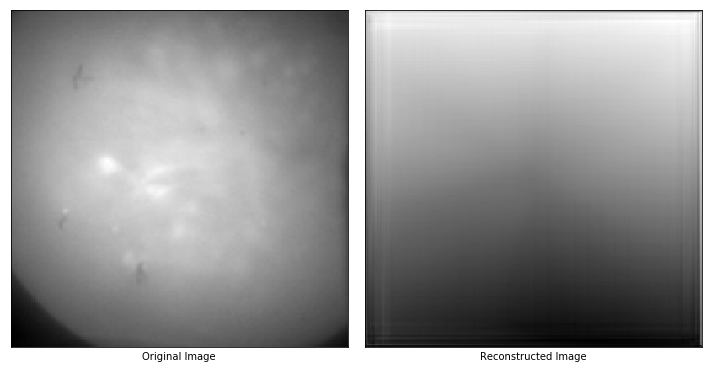

Step 100, Loss: 0.009001684375107288



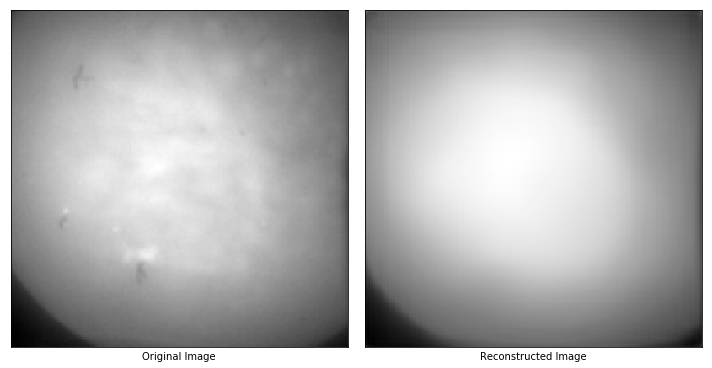

Step 200, Loss: 0.012893719598650932



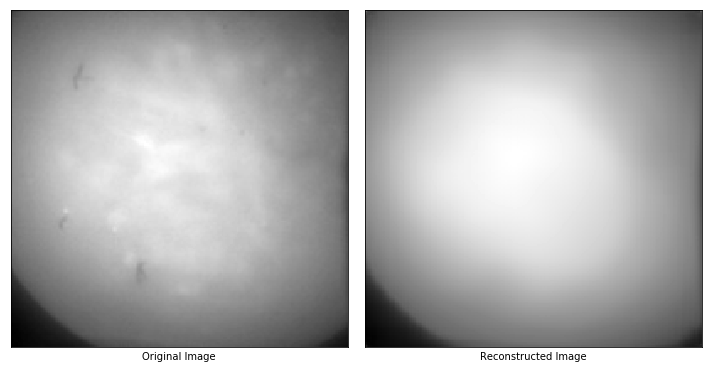

Step 300, Loss: 0.02069820836186409



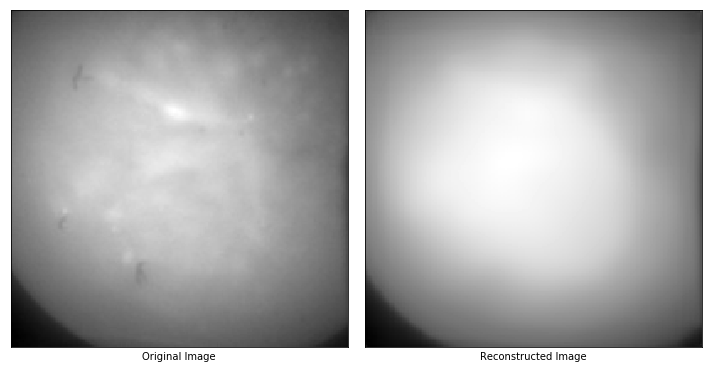

Step 400, Loss: 0.006247501354664564



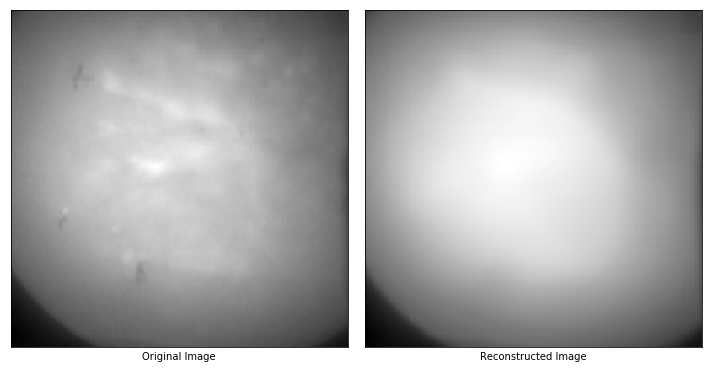

Step 500, Loss: 0.00682508759200573



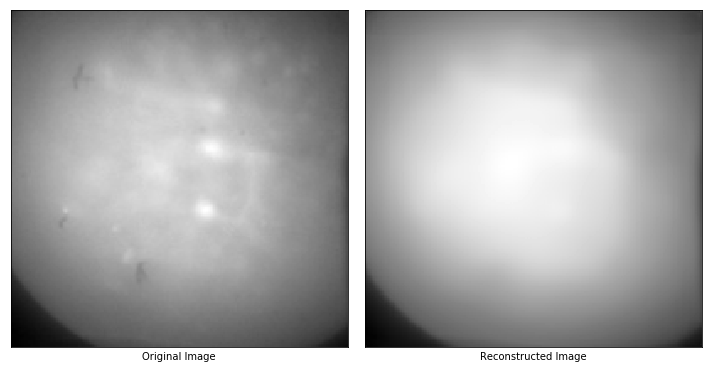

Step 600, Loss: 0.007642780430614948



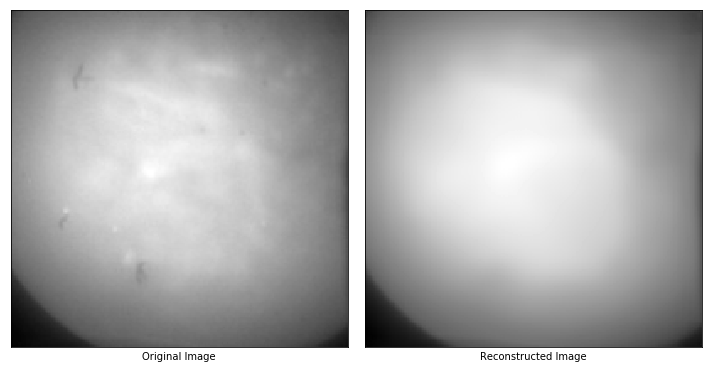

Step 700, Loss: 0.0061632683500647545



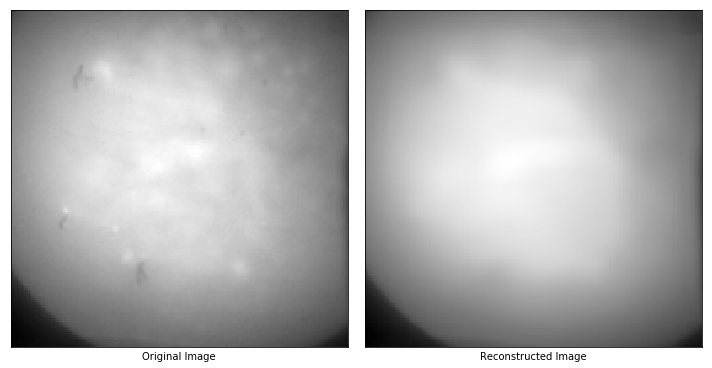

Step 800, Loss: 0.008418411016464233



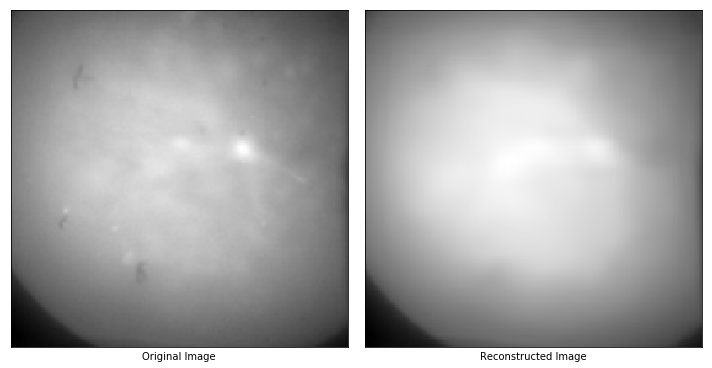

Step 900, Loss: 0.008295302279293537



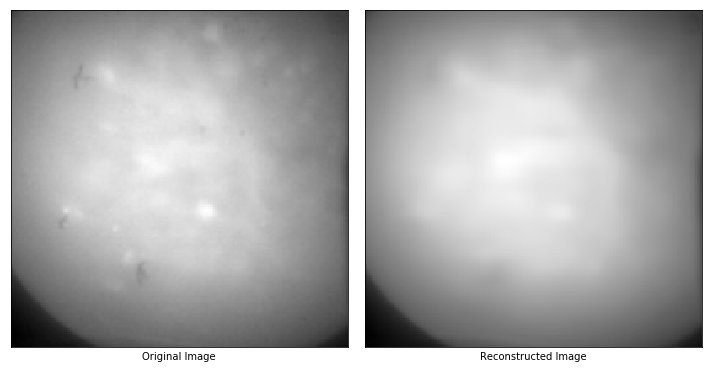

Step 1000, Loss: 0.006922828033566475



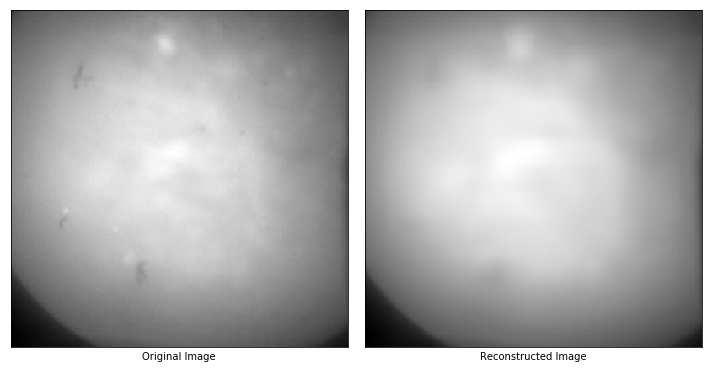

Step 1100, Loss: 0.00700319604948163



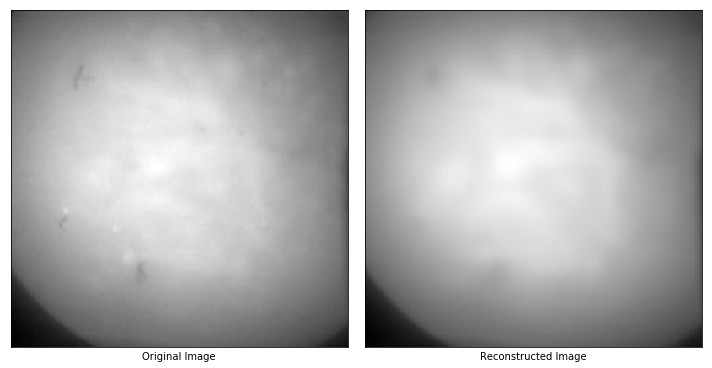

Step 1200, Loss: 0.009978815913200378



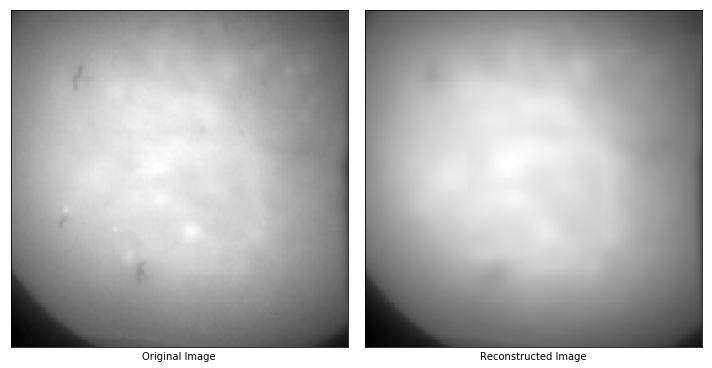

Step 1300, Loss: 0.008620540611445904



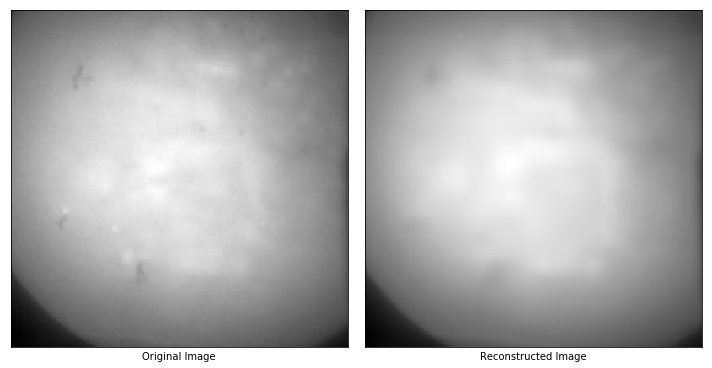

Step 1400, Loss: 0.006564863491803408



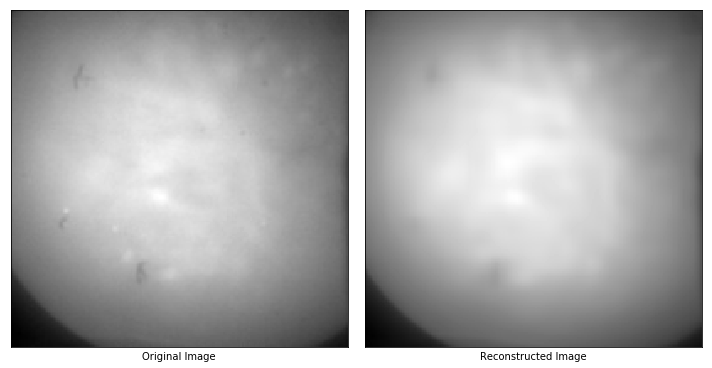

Step 1500, Loss: 0.006557990796864033



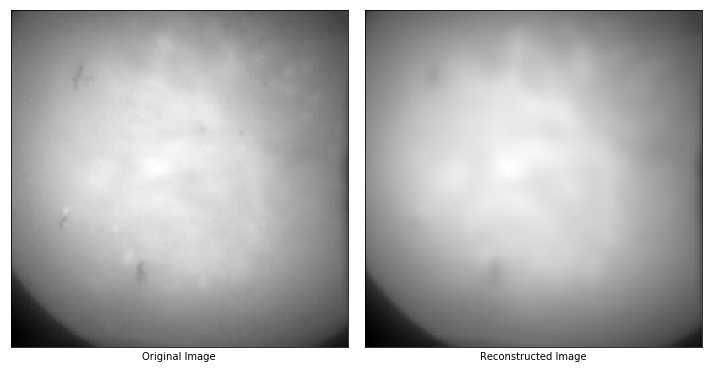

Step 1600, Loss: 0.007170355878770351



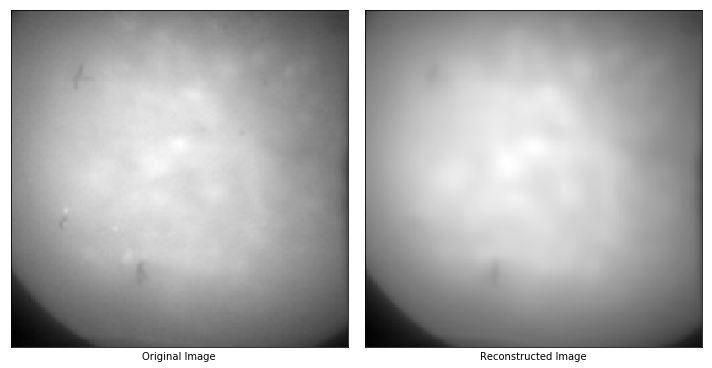

Step 1700, Loss: 0.006413971073925495



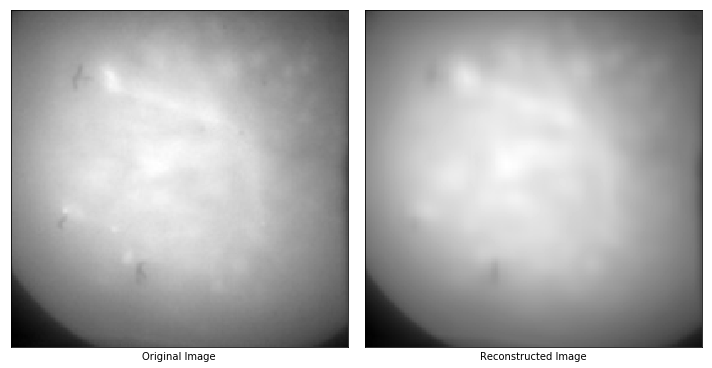

Step 1800, Loss: 0.00779661163687706



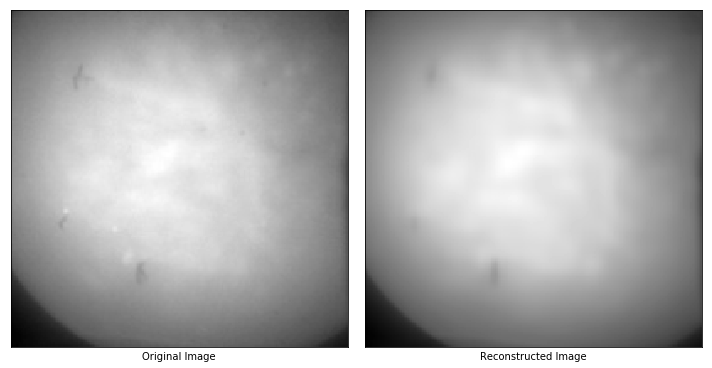

In [15]:
#loss function
#loss_fn = tf.losses.MeanSquaredError()
loss_fn = tf.losses.MeanAbsoluteError()
#loss_fn = tf.losses.BinaryCrossentropy()
#optimizer 
opt = tf.optimizers.Adam(lr)

max_step_num = int((len(re_list)*REPEAT)/BATCH_SIZE)
print('Total number of steps: ',max_step_num)
print()

@tf.function
def train(imgs):
    #w1 = encode_net.layers[-1].get_weights()
    
    with tf.GradientTape() as tape:
        encoded = encode_net(imgs)
        decoded = decode_net(encoded) #decoding encoder
        
        #xent = loss_fn(imgs, decoded) + l1_coeff*tf.math.reduce_mean(tf.math.abs(w1))
        xent = loss_fn(imgs, decoded)
        
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))
    
    return xent, decoded

ori_list = [] #original image list
de_list = [] #reconstructed image list
loss_list = [] #loss list

for step, (img_batch) in enumerate(ds_train):
    if step > MAX_STEP:
        break
        
    xent, de_img= train(img_batch)
    
    #store informatin in list
    ori_list.append(img_batch)
    de_list.append(de_img)
    
    if not step % 100:
        loss_list.append(xent)
        print("Step {}, Loss: {}".format(step, xent.numpy()))
        plot_2(img_batch[0], de_img[0], figsize = (10,10))

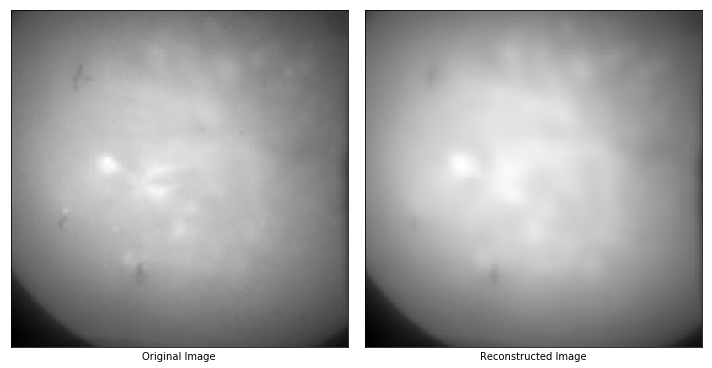

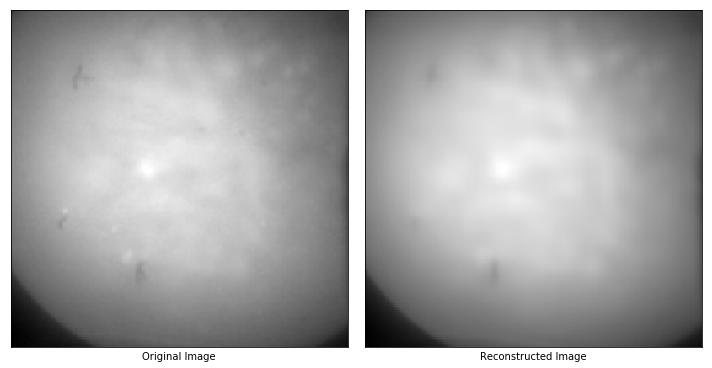

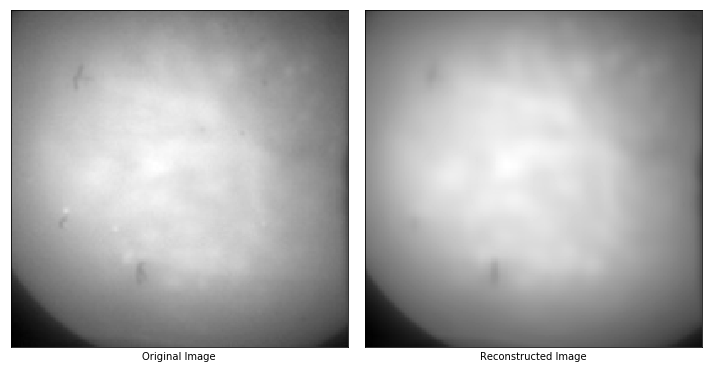

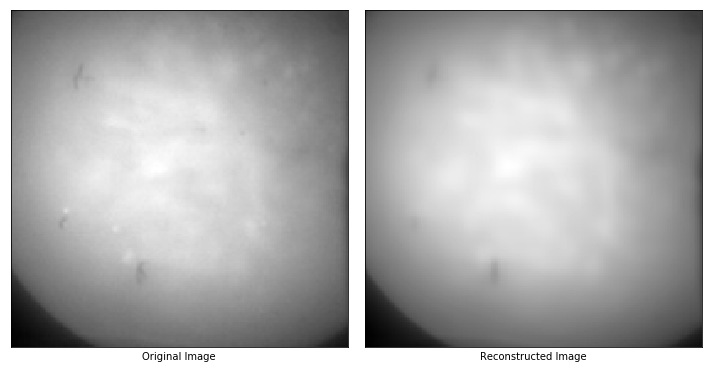

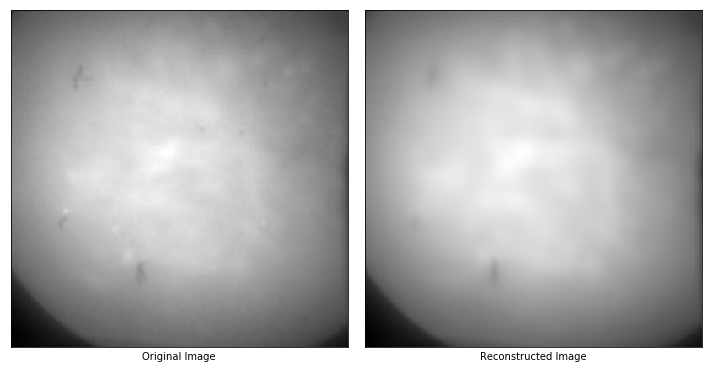

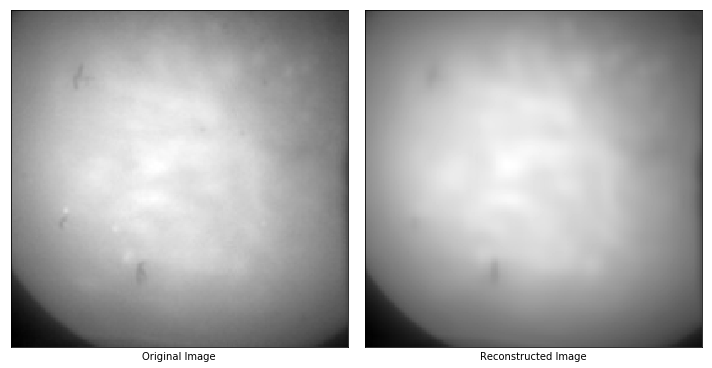

In [32]:
#check reconstruction

for i, (img_batch) in enumerate(ds_train):
    encoded = encode_net(img_batch)
    decoded = decode_net(encoded)
    
    plot_2(img_batch[0], decoded[0], figsize = (10,10))
    
    if i == 5: break

In [17]:
# ori_recon = zip(ori_list[max_step_num - 1], de_list[max_step_num - 1])

# for i, (ori, recon) in enumerate(ori_recon):
#     plot_2(ori, recon, figsize = (10,10))

# Loss and Feature Maps

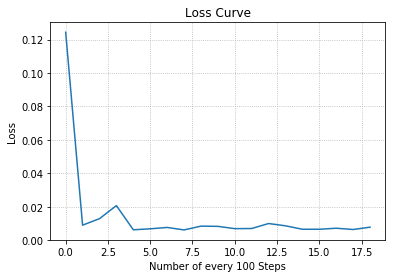

In [18]:
plot_loss(loss_list)

In [19]:
def layers_dict( model):
    '''
    :param model: deep learning model

    :return:
        Dictionary with 'key': layer names, value: layer information
    '''
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    return layer_dict

def feature_maps(model, layer_name, inps):
    '''
    This function visualize the intermediate activations of the filters within the layers
    :param model: deep learning model
    :param layer_name: desired layer name, if forgotten, please refer to layers_dict function
    :param inps: feed the network with input, such as images, etc. input dimension
                 should be 4.

    :return:
        feature maps of the layer specified by layer name,
        with dimension ( batch, row size, column size, channels)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"
    #retrieve key value from layers_dict
    layer_dict = layers_dict(model)

    #layer output with respect to the layer name
    layer_output = layer_dict[layer_name].output
    viz_model = Model(inputs=model.inputs, outputs=layer_output)
    feature_maps = viz_model.predict(inps)

    print('Shape of feature maps:', feature_maps.shape)
    #shape (batch, row size, column size, channels)
    return feature_maps

In [20]:
layer_dict = layers_dict(encode_net)
key_list = []
for key, value in layer_dict.items():
    key_list.append(key)
    print(key)

input_1
coord_conv
batch_normalization_v2
activation
coord_conv_1
batch_normalization_v2_1
activation_1
max_pooling2d
coord_conv_2
batch_normalization_v2_2
activation_2
max_pooling2d_1
coord_conv_3
activation_3
max_pooling2d_2


In [21]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
layer_output = layer_dict[layer_name].output

In [22]:
layer_output.shape

TensorShape([None, 200, 200, 32])

In [23]:
test_img = np.asarray(tf.expand_dims(re_list[0], 0))

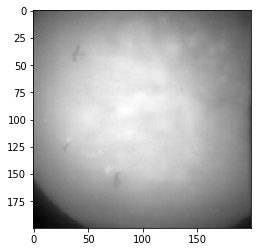

In [24]:
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

In [25]:
test_map = feature_maps(encode_net, '{}_2'.format(layer_name), test_img)

Shape of feature maps: (1, 100, 100, 64)


In [26]:
def plot_feature_maps(inps, row_num, col_num, figsize):
    '''
    This function can only plot the feature maps of a model
    :param inps: feature maps
    :param row_num: number of rows for the plot
    :param col_num: number of columns for the plot

    :return:
        grid plot of size (row_num * col_num)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"

    print("Number of feature maps in layer: ", inps.shape[-1])

    fig, axes = plt.subplots(row_num, col_num, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i, ax in enumerate(axes.flat):
        img = inps[0, :, :, i]

        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()

Number of feature maps in layer:  64


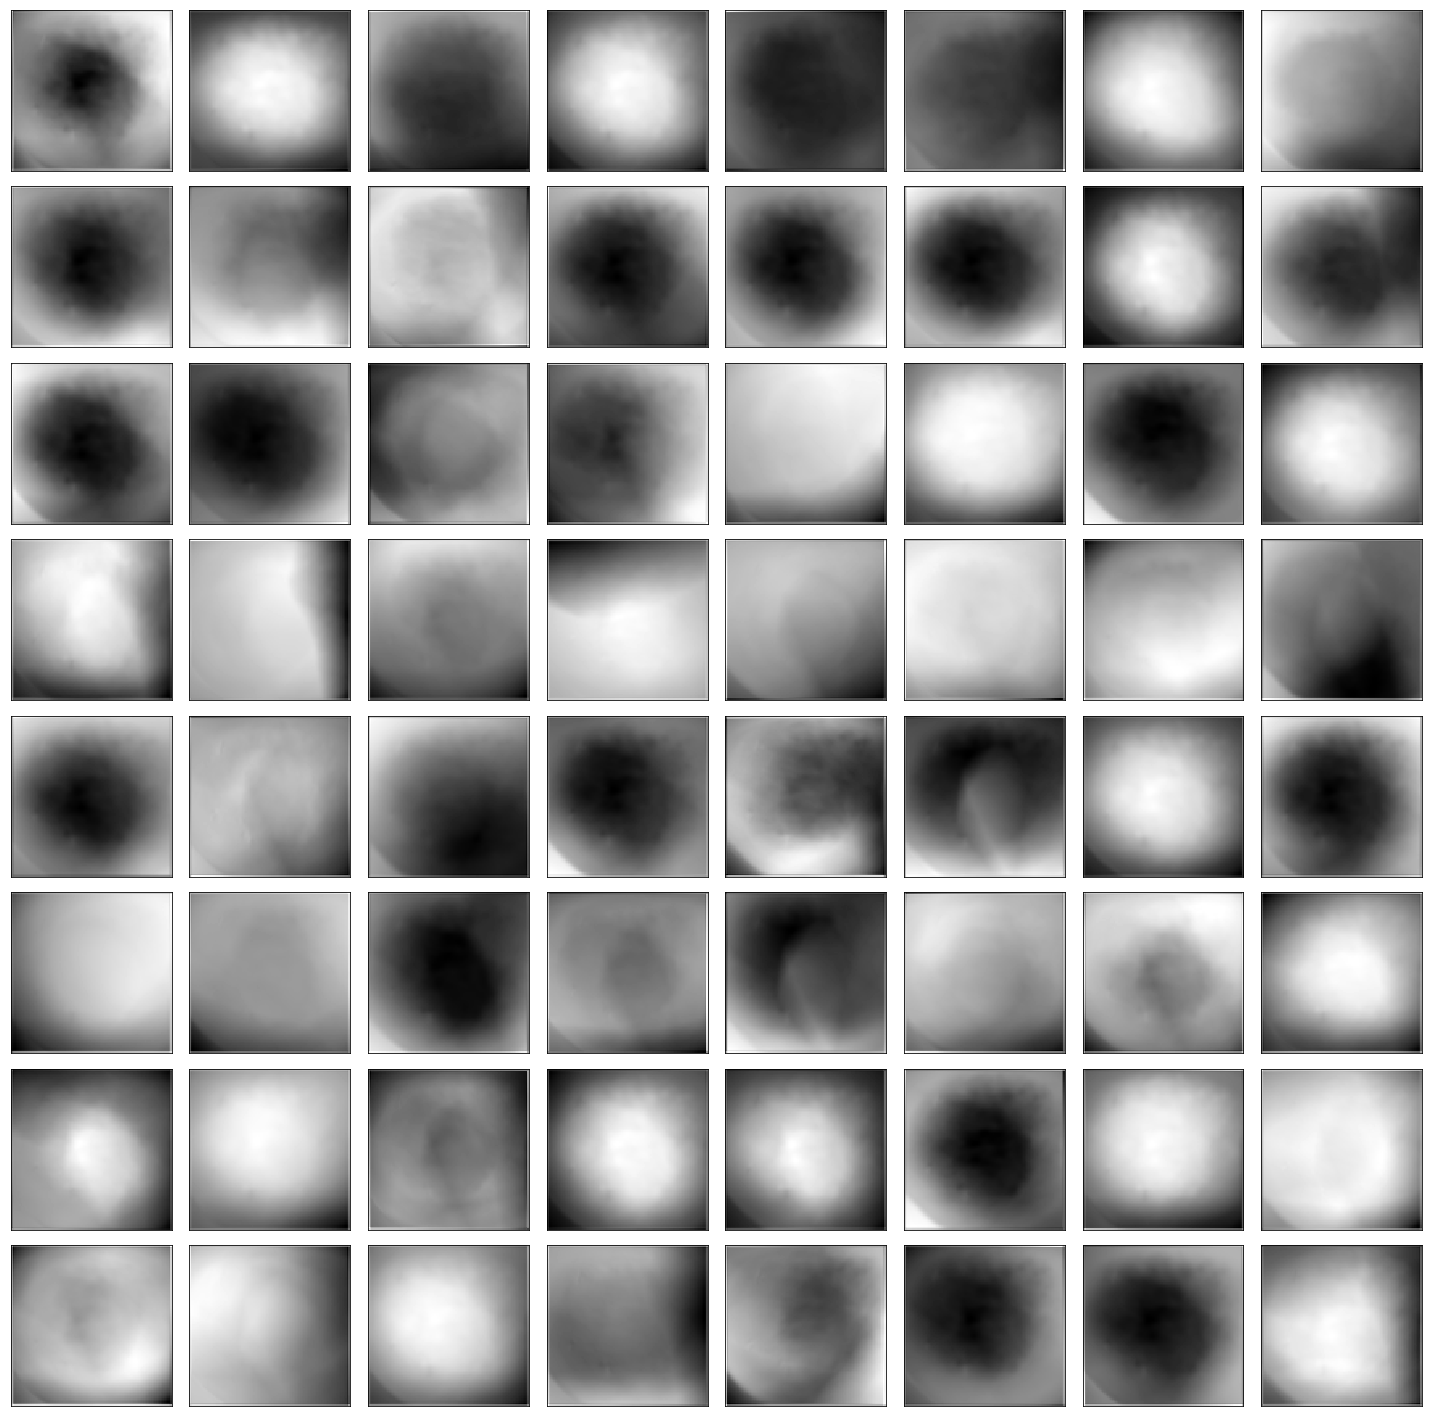

In [27]:
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

Shape of feature maps: (1, 200, 200, 32)
Number of feature maps in layer:  32


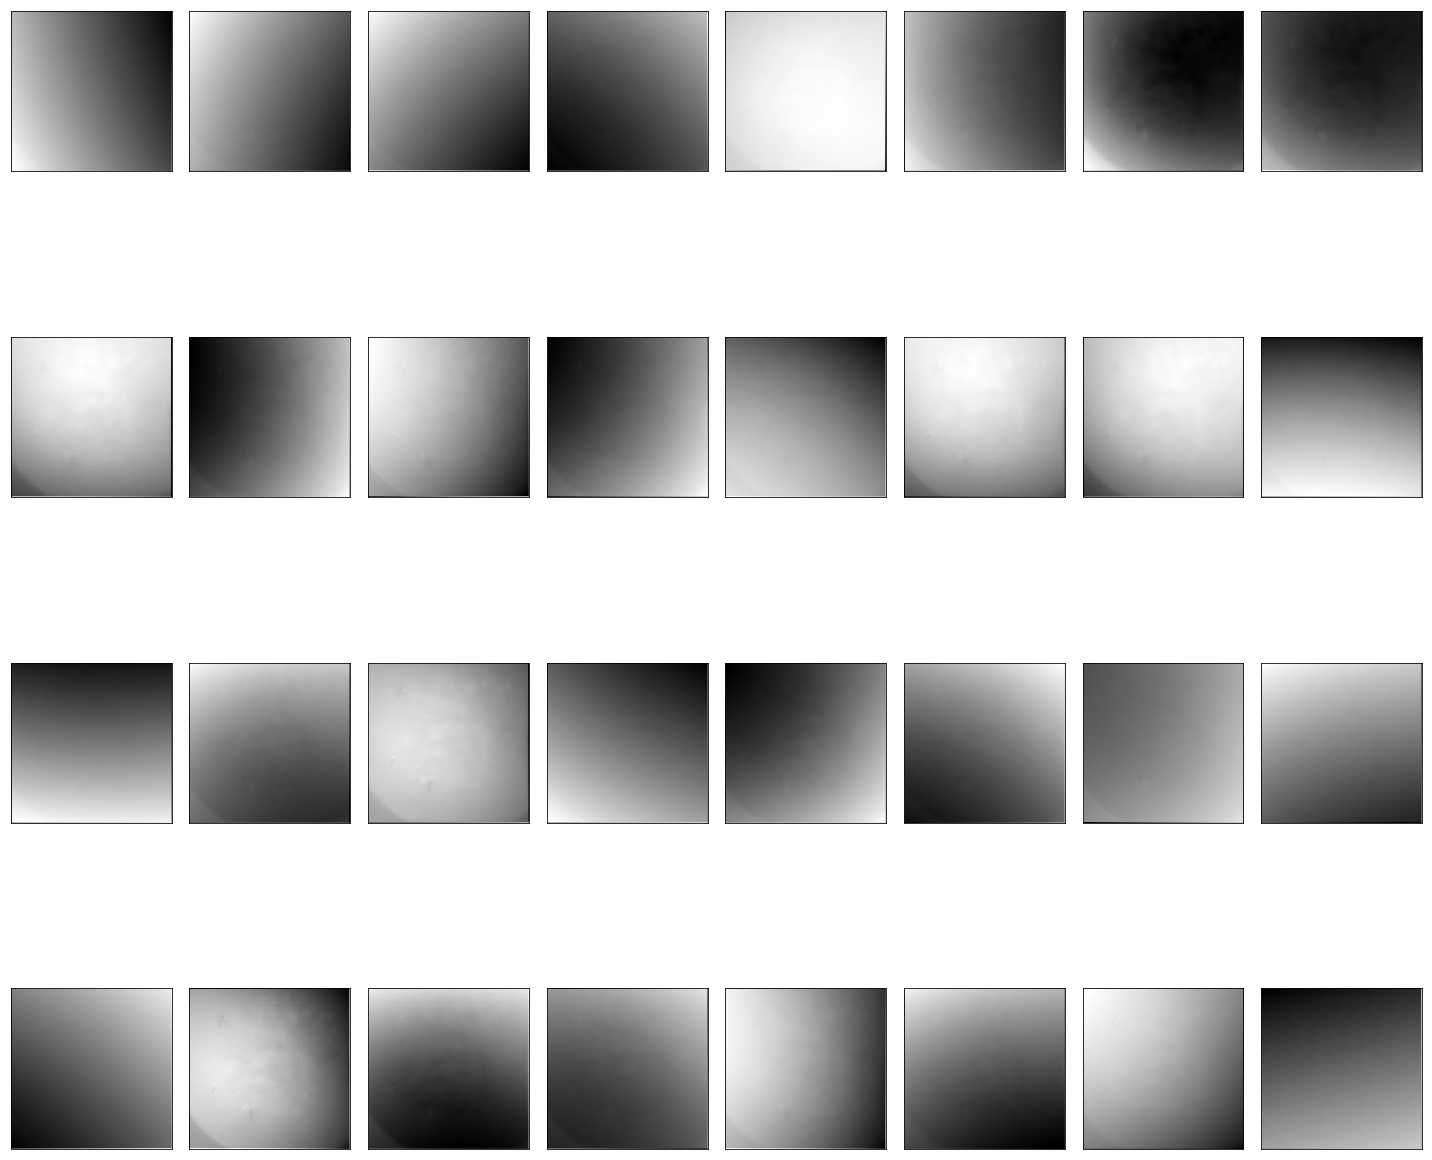

In [28]:
test_map02 = feature_maps(encode_net, '{}'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

In [29]:
encode_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
coord_conv (CoordConv)       (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 200, 200, 48)      14736     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 200, 200, 48)      192       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 48)      0     

In [30]:
decode_net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 25, 128)]     0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 50, 50, 128)       0         
_________________________________________________________________
coord_conv_4 (CoordConv)     (None, 50, 50, 64)        74944     
_________________________________________________________________
activation_4 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 100, 100, 64)      0         
_________________________________________________________________
coord_conv_5 (CoordConv)     (None, 100, 100, 48)      28560     
_________________________________________________________________
activation_5 (Activation)    (None, 100, 100, 48)      0   

In [31]:
# Autoencoder.summary()